# Imports

In [61]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation
from spellchecker import SpellChecker
# nltk.download('all')

In [42]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [4]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Functions

### 1. Data cleaning

In [80]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
    
    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def tokenization(text):
    tokens  = word_tokenize(text)

    return ' '.join(tokens)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
    

def lem_text(text):
    doc = nlp(text)
    lemma = ' '.join([token.lemma_ for token in doc])
    
    return lemma

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '')

    return replaced

def spell_correct(text):
    if text is None or not isinstance(text, str):
        return text

    spell = SpellChecker()

    # Find misspelled words
    misspelled = spell.unknown(text.split())

    # Correct misspelled words
    corrected_text = [spell.correction(word) if word in misspelled else word for word in text.split()]
    
    try:
        return ' '.join(corrected_text)
    except:
        return ' '.join(text)



### 2. Merge cleaning functions for one function

In [6]:
def preprocessing_data(text):
    
    text = remove_special_characters(text) #pass
    text = remove_punctuation(text) #pass
    text = convert_to_lowercase(text) #pass
    text = tokenization(text) #pass
    text = remove_stopwords(text) #pass
    text = lem_text(text) #pass
    text = replace(text) #pass
    return text

### 3. Restore basic forms of words

In [7]:
def lemmatization(text):
    doc = nlp(text)
    lem_tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    return ' '.join(lem_tokens)
    
    # return lem_text

def stemming(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

    # return stem_text

def remove_POS_tags(text):
    doc = nlp(text)
    result = [token.text for token in doc if token.tag_ == 'NN']  # check for nouns
    return ' '.join(result)
    # return remove_pos


#Write your function to extract the POS tags NN
# def extract_pos_tags(text):
#     doc = nlp(text)
#     sent = [token.text for token in doc if token.tag_ == 'NN']
#     return ' '.join(sent)

# finding ngrams

In [8]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [9]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [10]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [11]:

data = df # replace to have possibility to load back original data
data['clean'] = data['complaint_text'].apply(lambda x: preprocessing_data(x)) # new column with preprocessed data
# data_new['clean'] = data_new['clean'].apply(lambda x: remove_POS_tags(x))
data['clean'] = data['clean'].apply(lambda x: preprocessing_data(x))
data['clean'] = data['clean'].apply(lambda x: remove_POS_tags(x))
data.head()

,complaint_text,category,clean
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning name appreciate bank service write cha...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date agent info...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son check deposit chase account fund account m...


### Check data

(array([8.795e+03, 6.439e+03, 2.881e+03, 1.311e+03, 8.070e+02, 3.590e+02,
        1.570e+02, 8.200e+01, 5.700e+01, 4.600e+01, 3.100e+01, 2.500e+01,
        1.200e+01, 1.400e+01, 1.100e+01, 5.000e+00, 5.000e+00, 7.000e+00,
        2.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   249.4,   498.8,   748.2,   997.6,  1247. ,  1496.4,
         1745.8,  1995.2,  2244.6,  2494. ,  2743.4,  2992.8,  3242.2,
         3491.6,  3741. ,  3990.4,  4239.8,  4489.2,  4738.6,  4988. ,
         5237.4,  5486.8,  5736.2,  5985.6,  6235. ,  6484.4,  6733.8,
         6983.2,  7232.6,  7482. ,  7731.4,  7980.8,  8230.2,  8479.6,
         8729. ,  897

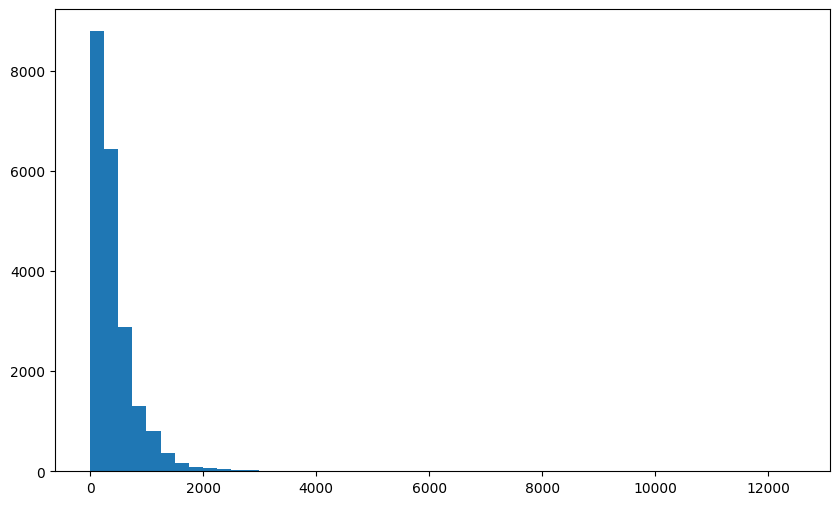

In [12]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data.clean]
doc_lens = [len(d) for d in data.clean]
plt.hist(doc_lens, bins = 50)

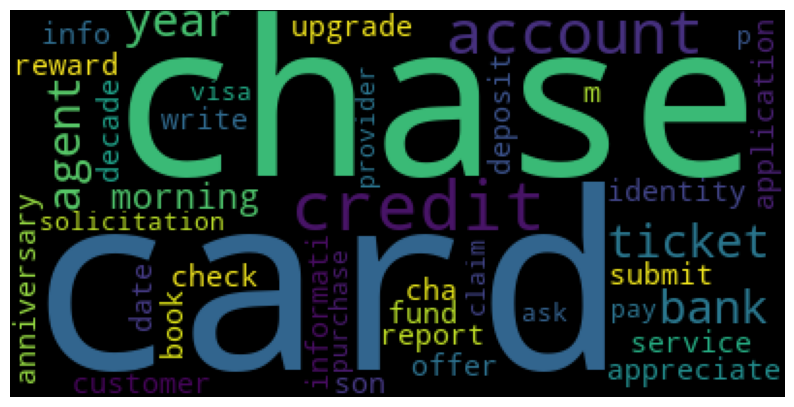

In [44]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [45]:
data.head(20)

,complaint_text,category,clean,Topic_NFM,Topic_LDA
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning name appreciate bank service write cha...,2,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date agent info...,1,4
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,3,1
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...,3,4
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son check deposit chase account fund account m...,0,0
15,Can you please remove inquiry,"Credit reporting, credit repair services, or o...",inquiry,3,1
17,With out notice J.P. Morgan Chase restricted m...,Checking or savings account+Checking account,account debit card branch customer service rep...,0,0
20,"During the summer months, I experience a decli...",Vehicle loan or lease+Loan,summer month experience decline income employm...,4,2
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","Money transfer, virtual currency, or money ser...",payment retailer chase pay chase website scam ...,1,0
23,I have a Chase credit card which is incorrectl...,Credit card or prepaid card+General-purpose cr...,chase credit card datum credit report company ...,3,1


# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

##### vectorizer - TFIDF

In [14]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
# vectorizer.get_feature_names_out()[:10]

In [15]:
dtm

<21072x6950 sparse matrix of type '<class 'numpy.float64'>'
	with 680360 stored elements in Compressed Sparse Row format>

# Topic Modelling

### Finding top n-grams

In [16]:
top_unigrams = get_top_ngrams(data['clean'], 1)
top_bigrams = get_top_ngrams(data['clean'], 2)
top_trigrams = get_top_ngrams(data['clean'], 3)

In [17]:
top_unigrams[:5]

[(('chase',), 59224),
 (('account',), 43657),
 (('credit',), 33786),
 (('card',), 30192),
 (('payment',), 21164)]

In [18]:
top_bigrams[:5]

[(('credit', 'card'), 12813),
 (('call', 'chase'), 3981),
 (('credit', 'report'), 3978),
 (('chase', 'credit'), 3375),
 (('check', 'account'), 3188)]

In [19]:
top_trigrams[:5]

[(('chase', 'credit', 'card'), 2435),
 (('credit', 'card', 'account'), 1066),
 (('credit', 'card', 'company'), 970),
 (('credit', 'card', 'chase'), 749),
 (('chase', 'customer', 'service'), 590)]

### Vectorizer - TF-IDF

In [29]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
feature_names = vectorizer.get_feature_names_out()

### NFM

In [26]:
nfm = NMF(n_components=5, random_state=42)
nfm.fit(dtm)

# change dtype from object to int
feature_mapping = {feature: idx for idx, feature in enumerate(feature_names)}
features_int = [feature_mapping[feature] for feature in feature_names]

for index,topic in enumerate(nfm.components_):
    top_words_indices = topic.argsort()[-15:]
    top_words = [features_int[i] for i in top_words_indices]

topics = nfm.transform(dtm)
dominant_topics = topics.argmax(axis=1)
data['Topic_NFM'] = dominant_topics

# print data
for index,topic in enumerate(nfm.components_):
    print("top 15 words for topic",  index)
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

top 15 words for topic 0
['customer', 'claim', 'business', 'number', 'transaction', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


top 15 words for topic 1
['claim', 'time', 'balance', 'use', 'fraud', 'merchant', 'service', 'transaction', 'fee', 'purchase', 'dispute', 'credit', 'chase', 'charge', 'card']


top 15 words for topic 2
['refinance', 'sale', 'foreclosure', 'request', 'time', 'rate', 'document', 'letter', 'year', 'property', 'home', 'modification', 'chase', 'mortgage', 'loan']


top 15 words for topic 3
['limit', 'remove', 'application', 'identity', 'chase', 'information', 'reporting', 'debt', 'company', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


top 15 words for topic 4
['mortgage', 'year', 'credit', 'account', 'date', 'auto', 'day', 'chase', 'time', 'statement', 'fee', 'pay', 'month', 'balance', 'payment']




### LDA

In [27]:
data['Topic_NFM'].value_counts()

Topic_NFM
1    6288
0    5393
2    3866
3    3133
4    2392
Name: count, dtype: int64

In [32]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Map feature names to integer indices
feature_mapping = {feature: idx for idx, feature in enumerate(feature_names)}
features_int = [feature_mapping[feature] for feature in feature_names]

# Print top words for each topic
for index, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[-15:]
    top_words = [features_int[i] for i in top_words_indices]

# Transform the document-term matrix using the LDA model
topics = lda.transform(dtm)

# Get dominant topics for each document
dominant_topics = topics.argmax(axis=1)

# Add a 'Topic' column to the DataFrame
data['Topic_LDA'] = dominant_topics

for index,topic in enumerate(nfm.components_):
    print("top 15 words for topic",  index)
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

top 15 words for topic 0
['customer', 'claim', 'business', 'number', 'transaction', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


top 15 words for topic 1
['claim', 'time', 'balance', 'use', 'fraud', 'merchant', 'service', 'transaction', 'fee', 'purchase', 'dispute', 'credit', 'chase', 'charge', 'card']


top 15 words for topic 2
['refinance', 'sale', 'foreclosure', 'request', 'time', 'rate', 'document', 'letter', 'year', 'property', 'home', 'modification', 'chase', 'mortgage', 'loan']


top 15 words for topic 3
['limit', 'remove', 'application', 'identity', 'chase', 'information', 'reporting', 'debt', 'company', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


top 15 words for topic 4
['mortgage', 'year', 'credit', 'account', 'date', 'auto', 'day', 'chase', 'time', 'statement', 'fee', 'pay', 'month', 'balance', 'payment']




In [33]:
data.head()

,complaint_text,category,clean,Topic_NFM,Topic_LDA
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning name appreciate bank service write cha...,2,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date agent info...,1,4
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,3,1
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...,3,4
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son check deposit chase account fund account m...,0,0


In [34]:
data.Topic_NFM.value_counts()

Topic_NFM
1    6288
0    5393
2    3866
3    3133
4    2392
Name: count, dtype: int64

In [35]:
data.Topic_LDA.value_counts()

Topic_LDA
0    7999
1    6064
2    4366
4    2420
3     223
Name: count, dtype: int64